Phase 1: Dataset Understanding - FaceForensics++

In [154]:
# CELL 1: Import required libraries

import os
import random
import cv2
import matplotlib.pyplot as plt


In [155]:
# CELL 2: Define dataset path 

DATASET_DIR = "/kaggle/input/ff-c23/FaceForensics++_C23"

os.listdir(DATASET_DIR)


['Face2Face',
 'csv',
 'Deepfakes',
 'DeepFakeDetection',
 'original',
 'NeuralTextures',
 'FaceShifter',
 'FaceSwap']

In [156]:
# CELL 3: Explore folder hierarchy
for root, dirs, files in os.walk(DATASET_DIR):
    print(f"\n📁 {root}")
    print("   Subfolders:", dirs)
    print("   Files:", files[:5])
    break



📁 /kaggle/input/ff-c23/FaceForensics++_C23
   Subfolders: ['Face2Face', 'csv', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']
   Files: []


In [157]:
# CELL 4: Select only valid video classes and count videos

def discover_video_classes(dataset_dir, video_extensions):
    classes = []
    class_counts = {}

    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)

        if os.path.isdir(folder_path):
            videos = [
                f for f in os.listdir(folder_path)
                if f.lower().endswith(video_extensions)
            ]

            if len(videos) > 0:
                classes.append(folder)
                class_counts[folder] = len(videos)

    return classes, class_counts

video_extensions = ('.mp4', '.avi', '.mov', '.mkv')

classes, class_counts = discover_video_classes(
    DATASET_DIR,
    video_extensions
)

print("Discovered classes:", classes)
print("Video count per class:", class_counts)


Discovered classes: ['Face2Face', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']
Video count per class: {'Face2Face': 1000, 'Deepfakes': 1000, 'DeepFakeDetection': 1000, 'original': 1000, 'NeuralTextures': 1000, 'FaceShifter': 1000, 'FaceSwap': 1000}


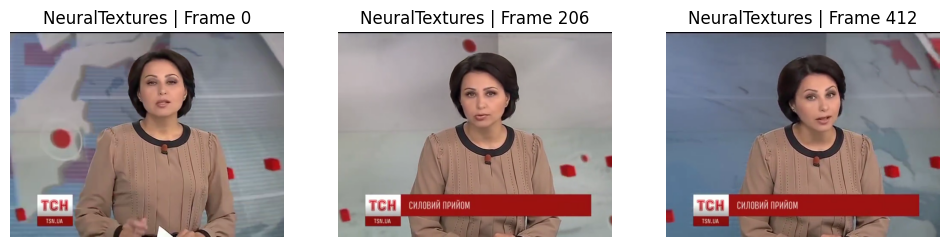

In [158]:
# CELL 5: Display 3 frames from a random video

# Select random class and video
selected_class = random.choice(classes)
video_folder = os.path.join(DATASET_DIR, selected_class)

video_name = random.choice([
    f for f in os.listdir(video_folder)
    if f.lower().endswith(video_extensions)
])

video_path = os.path.join(video_folder, video_name)

# Open video
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_ids = [0, frame_count // 2, frame_count - 1]

frames = []

for fid in frame_ids:
    cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

cap.release()

# Display frames
plt.figure(figsize=(12, 4))
for i, frame in enumerate(frames):
    plt.subplot(1, len(frames), i + 1)
    plt.imshow(frame)
    plt.title(f"{selected_class} | Frame {frame_ids[i]}")
    plt.axis("off")

plt.show()


In [159]:
# CELL 6: Dataset summary

total_videos = sum(class_counts.values())

print("Total classes:", len(classes))
print("Total videos:", total_videos)
print("\nVideos per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


Total classes: 7
Total videos: 7000

Videos per class:
Face2Face: 1000
Deepfakes: 1000
DeepFakeDetection: 1000
original: 1000
NeuralTextures: 1000
FaceShifter: 1000
FaceSwap: 1000


Phase 2: Data Preprocessing

In [160]:
# CELL 7: Additional libraries for preprocessing

import os
import cv2
import numpy as np
import torch
from tqdm import tqdm


In [161]:
# CELL 8: Preprocessing configuration 

NUM_FRAMES = 8              # frames per video
IMG_SIZE = 224              # resize to 224x224
MAX_VIDEOS_PER_CLASS = 10  # limit for faster experimentation (adjust later)

OUTPUT_DIR = "/kaggle/working/preprocessed_frames"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [162]:
# CELL 9: Function to extract N uniformly spaced frames

def extract_frames(video_path, num_frames=8):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < num_frames:
        cap.release()
        return []
    
    frame_ids = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    for fid in frame_ids:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames


In [163]:
# CELL 10: Load Face Detector & Funtion to Face detection and cropping

# Load Face Detector - HAAR Cascade
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

assert not face_cascade.empty(), "❌ Face cascade not loaded"

# Face Detect & Cropping
def detect_and_crop_face(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.3, minNeighbors=5
    )

    if len(faces) == 0:
        return None

    # take largest face
    x, y, w, h = sorted(
        faces, key=lambda b: b[2] * b[3], reverse=True
    )[0]

    face = frame[y:y+h, x:x+w]
    return face


In [164]:
# CELL 11: Resize face to IMG_SIZE x IMG_SIZE

def resize_face(face, img_size=224):
    try:
        face = cv2.resize(face, (img_size, img_size))
        return face
    except:
        return None


In [165]:
# CELL 12: Process frames of a single video

def process_video_frames(video_path, num_frames=8, img_size=224):
    frames = extract_frames(video_path, num_frames)
    
    processed_faces = []

    for frame in frames:
        face = detect_and_crop_face(frame)
        if face is None:
            continue
        
        face = resize_face(face, img_size)
        if face is None:
            continue
        
        processed_faces.append(face)

    # ensure fixed number of frames
    if len(processed_faces) < num_frames:
        return None

    return processed_faces


In [166]:
# CELL 13: Convert frames to tensor (no normalization)

def frames_to_tensor(frames):
    """
    frames: list of (H, W, C) numpy arrays
    returns: torch.Tensor (N, C, H, W)
    """
    frames = np.stack(frames)  # (N, H, W, C)
    tensor = torch.from_numpy(frames).permute(0, 3, 1, 2)
    return tensor


In [167]:
# CELL 14: Phase 2 - Run preprocessing pipeline (MULTICLASS)

def run_preprocessing_pipeline(
    dataset_dir,
    output_dir,
    classes,
    num_frames,
    img_size,
    video_extensions,
    max_videos_per_class=None
):
    os.makedirs(output_dir, exist_ok=True)

    # create output folders
    for cls in classes:
        os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

    summary = {cls: 0 for cls in classes}

    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)

        videos = [
            v for v in os.listdir(class_dir)
            if v.lower().endswith(video_extensions)
        ]

        if max_videos_per_class:
            videos = videos[:max_videos_per_class]

        for video in tqdm(videos, desc=f"Processing {cls}"):
            video_path = os.path.join(class_dir, video)

            frames = extract_frames(video_path, num_frames)
            if frames is None:
                continue

            processed_frames = []
            for frame in frames:
                face = detect_and_crop_face(frame)
                if face is None:
                    break

                face = resize_face(face, img_size)
                if face is None:
                    break

                processed_frames.append(face)

            if len(processed_frames) != num_frames:
                continue

            frames_tensor = frames_to_tensor(processed_frames)

            save_path = os.path.join(output_dir, cls, f"{video}.npz")

            np.savez_compressed(
                save_path,
                video_name=video,
                label=cls,
                frames=frames_tensor.numpy()  # convert tensor → numpy
            )

            summary[cls] += 1

    return summary

summary = run_preprocessing_pipeline(
    dataset_dir=DATASET_DIR,
    output_dir=OUTPUT_DIR,
    classes=classes,
    num_frames=NUM_FRAMES,
    img_size=IMG_SIZE,
    video_extensions=video_extensions,
    max_videos_per_class=MAX_VIDEOS_PER_CLASS
)

print("Preprocessing completed")
print("Summary (videos processed per class):")
for cls, count in summary.items():
    print(f"{cls}: {count}")


Processing FaceSwap: 100%|██████████| 10/10 [00:33<00:00,  3.34s/it]

Preprocessing completed
Summary (videos processed per class):
Face2Face: 10
Deepfakes: 10
DeepFakeDetection: 4
original: 9
NeuralTextures: 10
FaceShifter: 10
FaceSwap: 10


In [168]:
# CELL 15: Validate preprocessing output 

import glob
import numpy as np

def validate_preprocessing_output(output_dir, classes):
    all_files = []
    per_class_counts = {}

    for cls in classes:
        cls_files = glob.glob(os.path.join(output_dir, cls, "*.npz"))
        per_class_counts[cls] = len(cls_files)
        all_files.extend(cls_files)

    print("Preprocessing Summary")
    print("-" * 40)
    for cls, count in per_class_counts.items():
        print(f"{cls:20s}: {count}")

    print("-" * 40)
    print("Total processed videos:", len(all_files))

    # Inspect ONE sample safely (no torch.load)
    if len(all_files) > 0:
        sample = np.load(all_files[0], allow_pickle=True)

        print("\nSample file check")
        print("Keys:", sample.files)
        print("Label:", sample["label"].item())
        print("Frame array shape:", sample["frames"].shape)
        print("Frame dtype:", sample["frames"].dtype)

    return per_class_counts


# Run validation
summary = validate_preprocessing_output(OUTPUT_DIR, classes)


Preprocessing Summary
----------------------------------------
Face2Face           : 10
Deepfakes           : 10
DeepFakeDetection   : 4
original            : 9
NeuralTextures      : 10
FaceShifter         : 10
FaceSwap            : 10
----------------------------------------
Total processed videos: 63

Sample file check
Keys: ['video_name', 'label', 'frames']
Label: Face2Face
Frame array shape: (8, 3, 224, 224)
Frame dtype: uint8


In [169]:
# ZIP the preprocessing output so Kaggle exposes it for download

# import shutil
# import os

# OUTPUT_DIR = "/kaggle/working/preprocessed_frames"
# ZIP_PATH = "/kaggle/working/preprocessed_frames.zip"

# # Remove old zip if it exists
# if os.path.exists(ZIP_PATH):
#     os.remove(ZIP_PATH)

# shutil.make_archive(
#     base_name=ZIP_PATH.replace(".zip", ""),
#     format="zip",
#     root_dir=OUTPUT_DIR
# )

# print("ZIP created at:", ZIP_PATH)


Available classes: ['Face2Face', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']

Loading file: /kaggle/input/deepfake-phase2-preprocessed-frames-sample/Face2Face/315_322.mp4.npz

Sample metadata:
Label: Face2Face
Frames shape: (8, 3, 224, 224)
Frames dtype: uint8


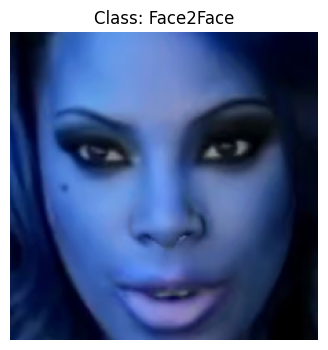

In [170]:
# Input validation: load and inspect one preprocessed file

import os
import numpy as np
import matplotlib.pyplot as plt

INPUT_PATH = "/kaggle/input/deepfake-phase2-preprocessed-frames-sample"

# Pick one class and one file
classes = os.listdir(INPUT_PATH)
print("Available classes:", classes)

sample_class = classes[0]
class_dir = os.path.join(INPUT_PATH, sample_class)

sample_file = os.listdir(class_dir)[0]
sample_path = os.path.join(class_dir, sample_file)

print("\nLoading file:", sample_path)

# Load .npz file
sample = np.load(sample_path, allow_pickle=True)

frames = sample["frames"]   # (N, C, H, W)
label = sample["label"].item()

print("\nSample metadata:")
print("Label:", label)
print("Frames shape:", frames.shape)
print("Frames dtype:", frames.dtype)

# Display first frame
frame_0 = frames[0].transpose(1, 2, 0)  # (C,H,W) → (H,W,C)

plt.figure(figsize=(4,4))
plt.imshow(frame_0)
plt.axis("off")
plt.title(f"Class: {label}")
plt.show()
